# MNIST patches

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Pad images with 5x5 padding

In [3]:
kernel_size = 5
train_images_padded = np.pad(train_images, ((0, 0), (kernel_size - 1, kernel_size - 1), (kernel_size - 1, kernel_size - 1)))
train_images_padded.shape

(60000, 36, 36)

In [4]:
def make_patches(image, p=5):
    width, height = image.shape
    patches = np.random.randn((width - p + 1) * (height - p + 1), p, p)
    for i in range(width - p + 1):
        for j in range(height - p + 1):
            patches[i * (height - p + 1) + j] = image[i:i + p, j:j + p]
            
    return patches

for img in train_images_padded[:1]:
    patches = make_patches(img)
patches.shape

(1024, 5, 5)

In [5]:
def out_size(img_size, kernel_size, stride, padding):
    return (img_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1

def conv2d_patches(img, kernel_size=(5, 5), stride=1, padding=0):
    (img_width, img_height) = img.shape
    (kernel_width, kernel_height) = kernel_size
    out_width, out_height = out_size(img_width, kernel_width, stride, padding), out_size(img_height, kernel_height, stride, padding)

    padded_img = np.pad(img, ((padding, padding), (padding, padding)))
    out = np.empty((out_width, out_height, kernel_width, kernel_height))
    for i, x in enumerate(range(0, out_width, stride)):
        for j, y in enumerate(range(0, out_height, stride)):
            out[i, j] = padded_img[x:x + kernel_width, y:y + kernel_height]
    return out / 255

wolla = conv2d_patches(train_images[0])

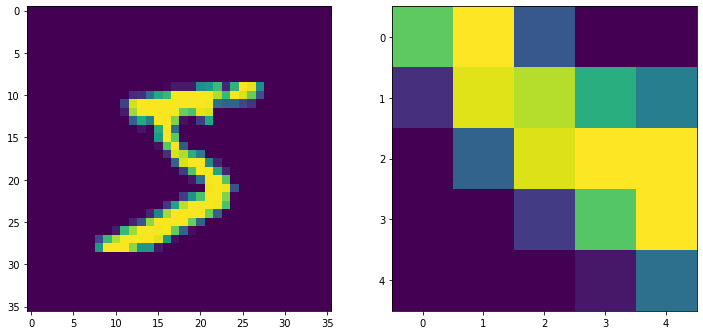

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(train_images_padded[0])
axs[1].imshow(wolla[12, 12])

## Neuron model

In [117]:
rng = np.random.default_rng()

class LIFEnsemble:
    
    def __init__(self, num_pixels, num_neurons):
        self.num_neurons = num_neurons

        self.exc_weights = rng.uniform(size=(num_neurons, num_pixels))
        self.inh_weights = np.zeros((num_neurons, num_neurons))
        self.thresholds = np.full(num_neurons, fill_value=5.0)

        self.reset()
        
        self.alpha = 0.01
        self.beta = 0.0001
        self.rho = 0.05
        self.gamma = 0.02

    def reset(self):        
        self.membrane_potential = np.zeros(self.num_neurons)
        self.input_current = np.zeros(self.num_neurons)
        self.spikes = [np.zeros(self.num_neurons)]
        
    def step(self, pixels):
        self.input_current = self.exc_weights @ pixels - self.inh_weights @ self.spikes[-1]
        self.membrane_potential += self.input_current
        
        self.spikes.append(self.membrane_potential >= self.thresholds)
        self.membrane_potential *= ~self.spikes[-1]
        
    def update(self, pixels):
        n_i = np.stack(self.spikes).sum(0)
        
        self.inh_weights += self.alpha * (np.outer(n_i, n_i) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0
        # self.inh_weights = np.minimum(self.inh_weights, 0)

        self.exc_weights += self.beta * np.outer(n_i, pixels - n_i @ self.exc_weights)
        # self.exc_weights = np.maximum(self.exc_weights, 0)

        self.thresholds += self.gamma * (n_i - self.rho)
        
        self.reset()        

In [100]:
def plot_activations(ensemble, sample_image):    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    for i, axs in enumerate(axs.flatten()):
        axs.imshow(ensemble.exc_weights[i].reshape(5, 5))
    plt.show()
    
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for filter_idx in range(16):
        image_activations = np.zeros((28, 28))
        image_padded = np.pad(sample_image, 4)
        for i in range(28):
            for j in range(28):
                activation = ensemble.exc_weights[filter_idx] @ image_padded[i:i + 5, j:j + 5].reshape(25)
                image_activations[i, j] = activation

        image_activations -= image_activations.min()
        image_activations /= image_activations.max()
        axs[filter_idx // 4][filter_idx % 4].imshow(image_activations, cmap='gray')

    fig.suptitle('Filter activations')
    plt.show()

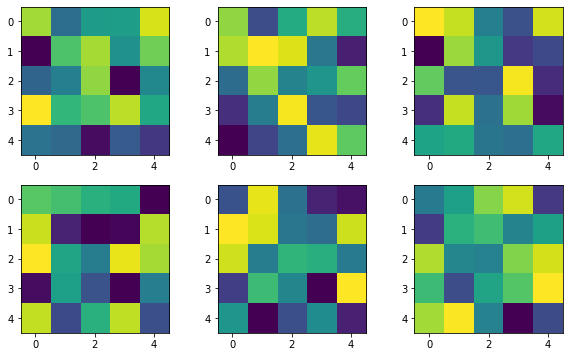

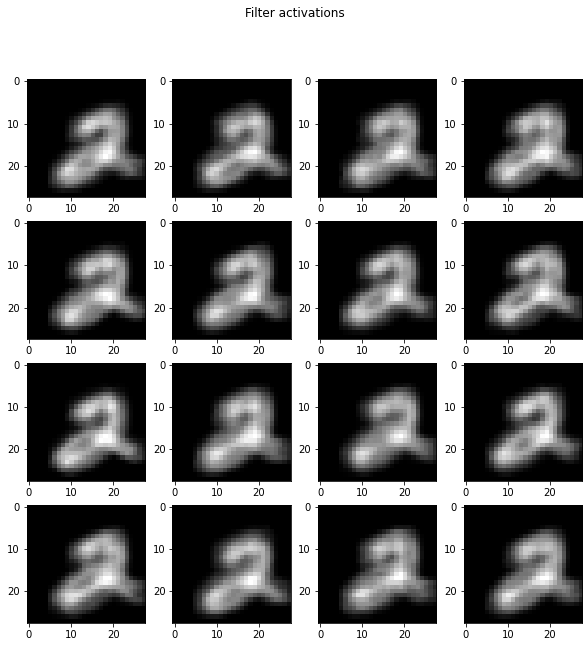

In [95]:
ensemble = LIFEnsemble(25, 16)
plot_activations(ensemble, train_images[5] / 255)

In [118]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:100]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(-1, 5, 5):
        for time_step in range(20):
            ensemble.step(patch.flatten())

        ensemble.update(patch.flatten())

  0%|          | 0/100 [00:00<?, ?it/s]

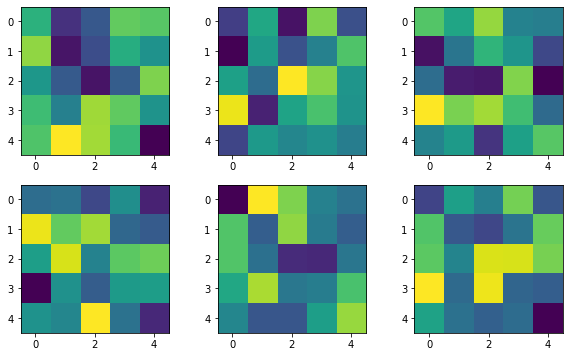

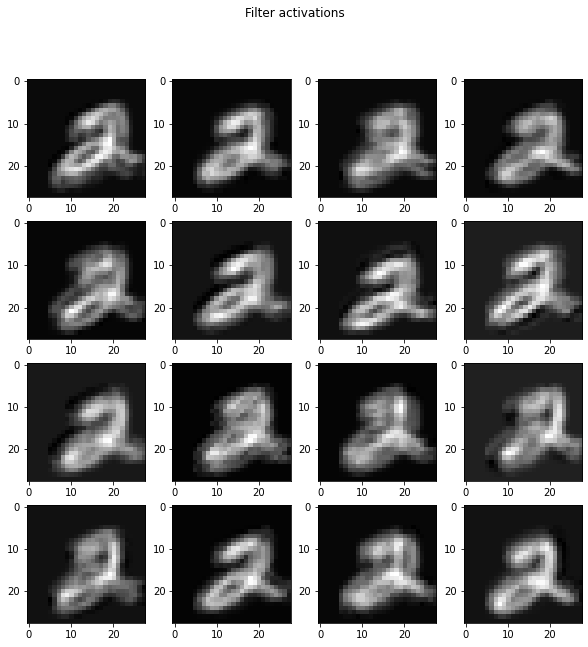

In [119]:
plot_activations(ensemble, train_images[5] / 255)

In [21]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:1000]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(-1, 5, 5):
        for time_step in range(20):
            ensemble.step(patch.flatten())

        ensemble.update(patch.flatten())

  0%|          | 0/1000 [00:00<?, ?it/s]

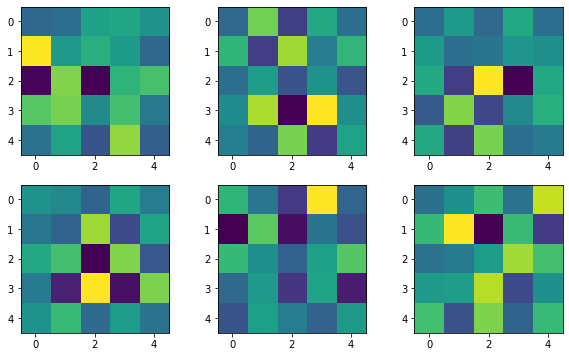

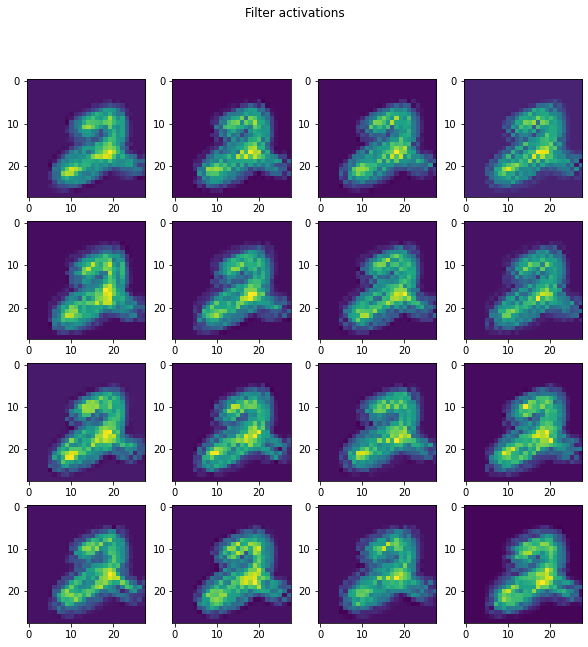

In [13]:
plot_activations(ensemble, train_images[5])

In [103]:
class IFEnsemble:    
    
    def __init__(self, input_values):
        self.input = input_values
        
        self.reset()
        
    def reset(self):
        self.membrane_potential = np.zeros(len(self.input))
        self.spikes = np.zeros(len(self.input))        

    def step(self):
        self.membrane_potential += self.input
        self.spikes = self.membrane_potential >= 1
        self.membrane_potential -= self.input * self.spikes
        
        return self.spikes

    
pixels_ensemble = IFEnsemble(train_images[0].flatten() / 255)
pixels_ensemble.step().sum()

1

In [126]:
class ConvLayer:
    
    def __init__(self, exc_weights, thresholds, num_pixels):
        self.exc_weights = exc_weights
        self.num_pixels = num_pixels
        self.num_filters = exc_weights.shape[0]
        
        self.reset()       

    def reset(self):        
        self.membrane_potential = np.zeros((576, self.num_filters))
        self.input_current = np.zeros((576, self.num_filters))
        self.spikes = [np.zeros((576, self.num_filters))]
        
    def run(self, pixels):
        pixels_ensemble = IFEnsemble(pixels.flatten())
        
        for t in range(20):
            pixel_spikes = pixels_ensemble.step().reshape(28, 28)
        
            patches = conv2d_patches(pixel_spikes * 255, padding=0).reshape(-1, 5*5)
            for i, patch_i in enumerate(patches):
                self.input_current[i] = self.exc_weights @ patch_i
                self.membrane_potential[i] += self.input_current[i]
            
            self.spikes.append(self.membrane_potential >= 1)
            self.membrane_potential *= ~self.spikes[-1]
        
        return np.stack(self.spikes[1:]).reshape(20, 24, 24, self.num_filters)
    
conv_layer = ConvLayer(ensemble.exc_weights, ensemble.thresholds, 28**2)
conv_spikes = conv_layer.run(train_images[0] / 255)
conv_spikes.sum()

79291

In [132]:
class PoolLayer:
    
    def __init__(self, img_shape):
        self.img_width, self.img_height = img_shape
        
    def run(self, conv_spikes):
        out_spikes = np.zeros(
            (20, self.img_width // 2, self.img_height // 2, conv_spikes.shape[-1])
        )

        for i in range(0, self.img_width, 2):
            for j in range(0, self.img_height, 2):
                for filter_i in range(16):
                    spike_patch = conv_spikes[:, i:i + 2, j:j + 2, filter_i]
                    max_neuron_idx = np.unravel_index(np.argmax(spike_patch.sum(0).reshape(4)), spike_patch.shape[1:])
                    out_spikes[:, i // 2, j // 2, filter_i] = spike_patch[:, max_neuron_idx[0], max_neuron_idx[1]]

        return out_spikes
                
pool_layer = PoolLayer((24, 24))
pooled_spikes = pool_layer.run(conv_spikes)
pooled_spikes.shape

(20, 12, 12, 16)

In [145]:
class STDPLayer:
    
    def __init__(self, num_inputs, num_outputs):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.weights = rng.uniform(size=(num_outputs, num_inputs))
        self.membrane_potential = np.zeros(num_outputs)
        self.spikes = []
        
        self.a_plus = 0.001
        self.a_minus = 0.00075
        self.epsilon = 5
        
    def step(self, pool_spikes):
        self.input_current = self.weights @ pool_spikes
        self.membrane_potential += self.input_current
        
        spike_probs = np.exp(self.membrane_potential) / np.sum(np.exp(self.membrane_potential))
        self.spikes.append((self.membrane_potential >= 0.5) * (spike_probs > 0.5))
        
        self.membrane_potential *= ~self.spikes[-1]
        
    def update(self, pool_spikes):
        self.spikes = np.stack(self.spikes)
        
        for time_step in range(20):
            for i, out_spike in enumerate(self.spikes[time_step]):
                if out_spike:
                    for pre_neuron in range(self.num_inputs):
                        if np.any(pool_spikes[time_step - 5:time_step, pre_neuron]):
                            self.weights[i, pre_neuron] += self.a_plus * np.exp(-self.weights[i, pre_neuron])
                        else:
                            self.weights[i, pre_neuron] -= self.a_minus
                            
stdp_layer = STDPLayer(144 * 16, 100)
for t in range(20):
    stdp_layer.step(pooled_spikes[t].reshape(-1))
stdp_layer.update(pooled_spikes.reshape(20, -1))

C:\Users\NIELS-~1\AppData\Local\Temp/ipykernel_4712/433266884.py:19: RuntimeWarning: overflow encountered in exp
  spike_probs = np.exp(self.membrane_potential) / np.sum(np.exp(self.membrane_potential))
C:\Users\NIELS-~1\AppData\Local\Temp/ipykernel_4712/433266884.py:19: RuntimeWarning: invalid value encountered in true_divide
  spike_probs = np.exp(self.membrane_potential) / np.sum(np.exp(self.membrane_potential))


In [148]:
stdp_layer.weights

array([[0.87156128, 0.68012048, 0.9821951 , ..., 0.37452442, 0.36837683,
        0.98878378],
       [0.35666328, 0.28425242, 0.2574952 , ..., 0.09636676, 0.55188442,
        0.47866072],
       [0.71962604, 0.80799701, 0.58984441, ..., 0.17529671, 0.00530281,
        0.11651982],
       ...,
       [0.98367557, 0.10165322, 0.26547049, ..., 0.57298044, 0.39782947,
        0.6462416 ],
       [0.70688739, 0.20236383, 0.75340797, ..., 0.83245281, 0.04067841,
        0.62090735],
       [0.18361448, 0.08502619, 0.14302981, ..., 0.44125922, 0.80384088,
        0.6609135 ]])

In [137]:
pooled_spikes[t].reshape(-1).shape

(2304,)